# Feature Selection and Dimensionality Reduction
According to [wikipedia](https://en.wikipedia.org/wiki/Feature_selection), "feature selection is the process of selecting a subset of relevent features for use in model construction".  In normal circumstances, domain knowledge plays an important role.  Unfortunately, here in the Don't Overfit II competition, we have a binary target and 300 continuous variables "of mysterious origin" which forces us to try automatic feature selection techniques.

In this kernel we will explore the following feature selection and dimensionality reduction techniques:

1. Remove features with missing values
2. Remove features with low variance
3. Remove highly correlated features
4. Univariate feature selection
5. Recursive feature elimination
6. Feature selection using SelectFromModel
7. PCA

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [2]:
# setting up default plotting parameters
%matplotlib inline

plt.rcParams['figure.figsize'] = [20.0, 7.0]
plt.rcParams.update({'font.size': 22,})

sns.set_palette('viridis')
sns.set_style('white')
sns.set_context('talk', font_scale=0.8)

In [3]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

print('Train Shape: ', train.shape)
print('Test Shape: ', test.shape)

train.head()

Train Shape:  (250, 302)
Test Shape:  (19750, 301)


,id,target,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,...,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
0,0,1.0,-0.098,2.165,0.681,-0.614,1.309,-0.455,-0.236,0.276,-2.246,1.825,-0.912,-0.107,0.305,0.102,0.826,0.417,0.177,-0.673,-0.503,1.864,0.410,-1.927,0.102,-0.931,1.763,1.449,-1.097,-0.686,-0.250,-1.859,1.125,1.009,-2.296,0.385,-0.876,1.528,-0.144,-1.078,...,-0.681,1.250,-0.565,-1.318,-0.923,0.075,-0.704,2.457,0.771,-0.460,0.569,-1.320,-1.516,-2.145,-1.120,0.156,0.820,-1.049,-1.125,0.484,0.617,1.253,1.248,0.504,-0.802,-0.896,-1.793,-0.284,-0.601,0.569,0.867,1.347,0.504,-0.649,0.672,-2.097,1.051,-0.414,1.038,-1.065
1,1,0.0,1.081,-0.973,-0.383,0.326,-0.428,0.317,1.172,0.352,0.004,-0.291,2.907,1.085,2.144,1.540,0.584,1.133,1.098,-0.237,-0.498,0.283,-1.100,-0.417,1.382,-0.515,-1.519,0.619,-0.128,0.866,-0.540,1.238,-0.227,0.269,-0.390,-2.721,1.659,0.106,-0.121,1.719,...,0.971,-1.489,0.530,0.917,-0.094,-1.407,0.887,-0.104,-0.583,1.267,-1.667,-2.771,-0.516,1.312,0.491,0.932,2.064,0.422,1.215,2.012,0.043,-0.307,-0.059,1.121,1.333,0.211,1.753,0.053,1.274,-0.612,-0.165,-1.695,-1.257,1.359,-0.808,-1.624,-0.458,-1.099,-0.936,0.973
2,2,1.0,-0.523,-0.089,-0.348,0.148,-0.022,0.404,-0.023,-0.172,0.137,0.183,0.459,0.478,-0.425,0.352,1.095,0.300,-1.044,0.270,-1.038,0.144,-1.658,-0.946,0.633,-0.772,1.786,0.136,-0.103,-1.223,2.273,0.055,-2.032,-0.452,0.064,0.924,-0.692,-0.067,-0.917,1.896,...,-0.540,-0.299,1.074,-0.748,1.086,-0.766,-0.931,0.432,1.345,-0.491,-1.602,-0.727,0.346,0.780,-0.527,-1.122,-0.208,-0.730,-0.302,2.535,-1.045,0.037,0.020,1.373,0.456,-0.277,1.381,1.843,0.749,0.202,0.013,0.263,-1.222,0.726,1.444,-1.165,-1.544,0.004,0.800,-1.211
3,3,1.0,0.067,-0.021,0.392,-1.637,-0.446,-0.725,-1.035,0.834,0.503,0.274,0.335,-1.148,0.067,-1.010,1.048,-1.442,0.210,0.836,-0.326,0.716,-0.764,0.248,-1.308,2.127,0.365,0.296,-0.808,1.854,0.118,0.380,0.999,-1.171,2.798,0.394,-1.048,1.078,0.401,-0.486,...,-0.083,-0.831,1.251,-0.206,-0.933,-1.215,0.281,0.512,-0.424,0.769,0.223,-0.710,2.725,0.176,0.845,-1.226,1.527,-1.701,0.597,0.150,1.864,0.322,-0.214,1.282,0.408,-0.910,1.020,-0.299,-1.574,-1.618,-0.404,0.640,-0.595,-0.966,0.900,0.467,-0.562,-0.254,-0.533,0.238
4,4,1.0,2.347,-0.831,0.511,-0.021,1.225,1.594,0.585,1.509,-0.012,2.198,0.190,0.453,0.494,1.478,-1.412,0.270,-1.312,-0.322,-0.688,-0.198,-0.285,1.042,-0.315,-0.478,0.024,-0.190,1.656,-0.469,-1.437,-0.581,-0.308,-0.837,-1.739,0.037,0.336,-1.102,2.371,0.554,...,-1.050,-0.347,0.904,-1.324,-0.849,3.432,0.222,0.416,0.174,-1.517,-0.337,0.055,-0.464,0.014,-1.073,0.325,-0.523,-0.692,0.190,-0.883,-1.830,1.408,2.319,1.704,-0.723,1.014,0.064,0.096,-0.775,1.845,0.898,0.134,2.415,-0.996,-1.006,1.378,1.246,1.478,0.428,0.253


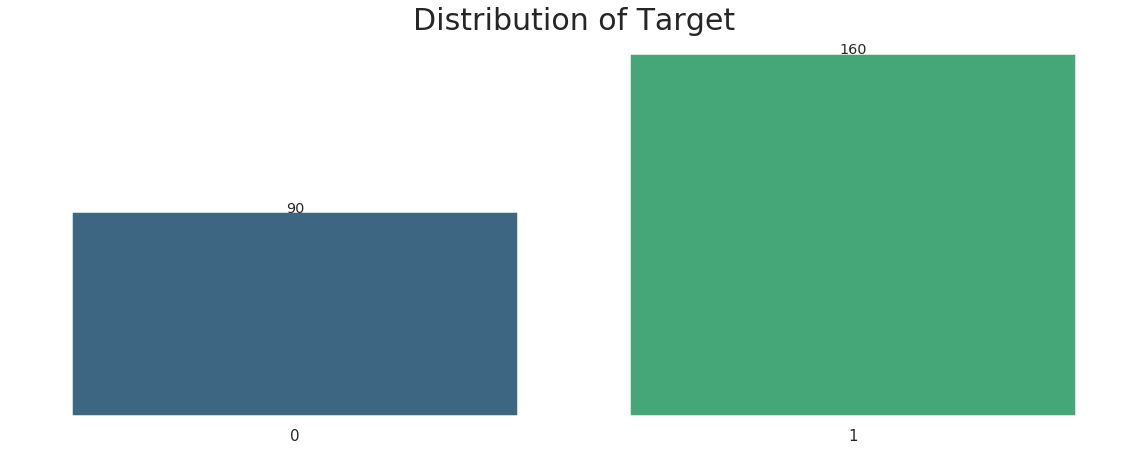

In [4]:
# using seaborns countplot to show distribution of questions in dataset
fig, ax = plt.subplots()
g = sns.countplot(train.target, palette='viridis')
g.set_xticklabels(['0', '1'])
g.set_yticklabels([])

# function to show values on bars
def show_values_on_bars(axs):
    def _show_on_single_plot(ax):        
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height()
            value = '{:.0f}'.format(p.get_height())
            ax.text(_x, _y, value, ha="center") 

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)
show_values_on_bars(ax)

sns.despine(left=True, bottom=True)
plt.xlabel('')
plt.ylabel('')
plt.title('Distribution of Target', fontsize=30)
plt.tick_params(axis='x', which='major', labelsize=15)
plt.show()

## Baseline Models
We'll use logistic regression is a good baseline as it is fast to train and predict and scales well.  We'll also use random forest.  With  its attribute feature_importances_ we can get a sense of which features are most important.

The logistic regression baseline model scored 0.666 on the public leaderboard.

In [5]:
# prepare for modeling
X_train_df = train.drop(['id', 'target'], axis=1)
y_train = train['target']

X_test = test.drop(['id'], axis=1)

# scaling data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_df)
X_test = scaler.transform(X_test)

In [6]:
lr = LogisticRegression(solver='liblinear')
rfc = RandomForestClassifier(n_estimators=100)

lr_scores = cross_val_score(lr,
                            X_train,
                            y_train,
                            cv=5,
                            scoring='roc_auc')
rfc_scores = cross_val_score(rfc, X_train, y_train, cv=5, scoring='roc_auc')

print('LR Scores: ', lr_scores)
print('RFC Scores: ', rfc_scores)

LR Scores:  [0.80729167 0.71875    0.734375   0.80034722 0.66319444]
RFC Scores:  [0.70052083 0.70486111 0.64670139 0.73958333 0.51649306]


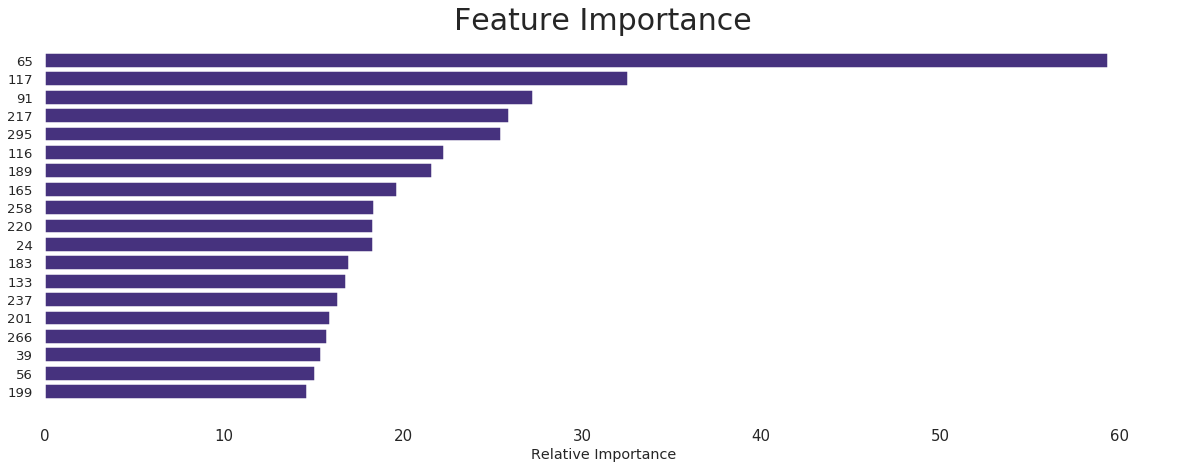

In [7]:
# checking which are the most important features
feature_importance = rfc.fit(X_train, y_train).feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
sorted_idx = sorted_idx[-20:-1:1]
pos = np.arange(sorted_idx.shape[0]) + .5
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train_df.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Feature Importance', fontsize=30)
plt.tick_params(axis='x', which='major', labelsize=15)
sns.despine(left=True, bottom=True)
plt.show()

While logistic regression is clearly the superior model, we can see that both modesl are likely overfitting from the fluctuating cross validation scores.  We can apply feature selection techniques to improve model performance.

## 1.  Remove features with missing values
This one is pretty self explanatory.  First we check for missing values and then can remove columns exceeding a threshold we define.

In [8]:
# check missing values
train.isnull().any().any()

False

The dataset has no missing values and therefore no features to remove at this step.

## 2.  Remove features with low variance
In sklearn's feature selection module we find VarianceThreshold.  It removes all features whose variance doesn't meet some threshold.  By default it removes features with zero variance or features that have the same value for all samples.


In [9]:
from sklearn import feature_selection

sel = feature_selection.VarianceThreshold()
train_variance = sel.fit_transform(train)
train_variance.shape

(250, 302)

The competition description stated that our features are all continuous.  We can see from above there are no features with the same value in all columns, so we have no features to remove here.  We can revisit this technique later and consider removing features with low variance later.

## 3.  Remove highly correlated features

Features that are highly correlated or colinear can cause overfitting.  Here we will explore correlations among features.

In [10]:
# find correlations to target
corr_matrix = train.corr().abs()

print(corr_matrix['target'].sort_values(ascending=False).head(10))

target    1.000000
33        0.373608
65        0.293846
217       0.207215
117       0.197496
91        0.192536
24        0.173096
295       0.170501
73        0.167557
183       0.164146
Name: target, dtype: float64


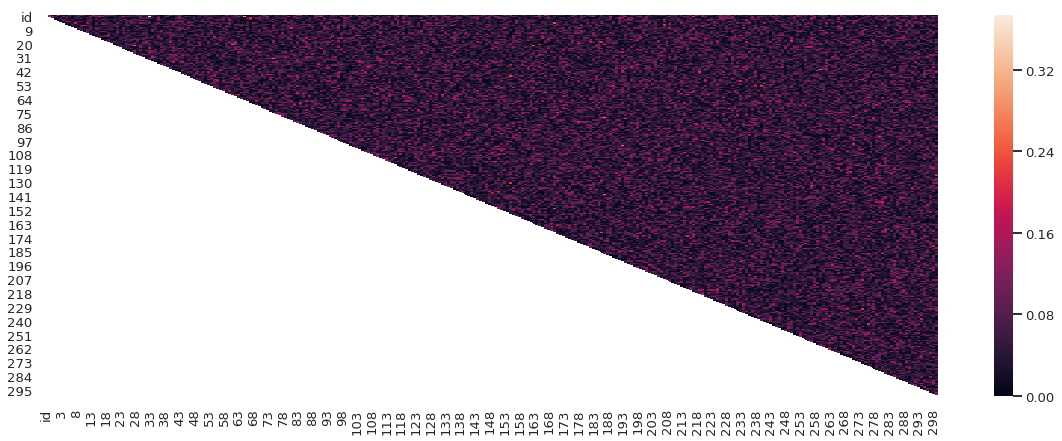

In [11]:
# Select upper triangle of correlation matrix
matrix = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
sns.heatmap(matrix)
plt.show;

In [12]:
# Find index of feature columns with high correlation
to_drop = [column for column in matrix.columns if any(matrix[column] > 0.50)]
print('Columns to drop: ' , (len(to_drop)))

Columns to drop:  0


From the above correlation matrix we see that there are no highly correlated features in the dataset.  And even exploring correlation to target shows feature 33 with the highest correlation of only 0.37.

## 4.  Univariate Feature Selection
We can use sklearn's SelectKBest to select a number of features to keep.  This method uses statistical tests to select features having the highest correlation to the target.  Here we will keep the top 100 features.

In [13]:
# feature extraction
k_best = feature_selection.SelectKBest(score_func=feature_selection.f_classif, k=100)
# fit on train set
fit = k_best.fit(X_train, y_train)
# transform train set
univariate_features = fit.transform(X_train)

In [14]:
lr = LogisticRegression(solver='liblinear')
rfc = RandomForestClassifier(n_estimators=100)

lr_scores = cross_val_score(lr, univariate_features, y_train, cv=5, scoring='roc_auc')
rfc_scores = cross_val_score(rfc, univariate_features, y_train, cv=5, scoring='roc_auc')

print('LR Scores: ', lr_scores)
print('RFC Scores: ', rfc_scores)

LR Scores:  [0.89930556 0.93402778 0.89236111 0.96006944 0.94791667]
RFC Scores:  [0.73350694 0.87326389 0.83680556 0.7421875  0.90451389]


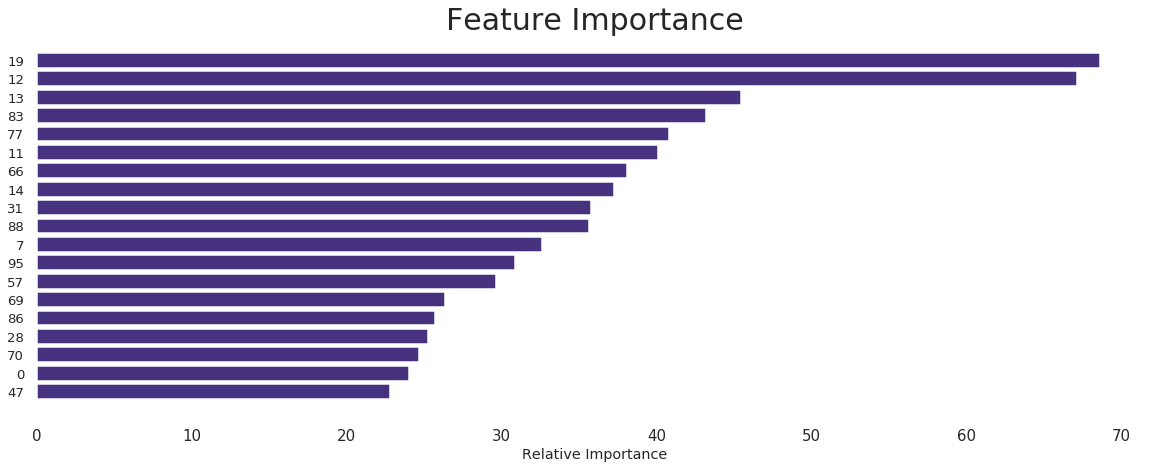

In [29]:
# checking which are the most important features
feature_importance = rfc.fit(univariate_features, y_train).feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
sorted_idx = sorted_idx[-20:-1:1]
pos = np.arange(sorted_idx.shape[0]) + .5
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train_df.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Feature Importance', fontsize=30)
plt.tick_params(axis='x', which='major', labelsize=15)
sns.despine(left=True, bottom=True)
plt.show()

Our cross validation scores are improved as compared to the baseline above, but we still can see variation in the scores which indicates overfitting.  

Logistic Regression Public Leaderboard Score: 0.676

## 5.  Recursive Feature Elimination

Recursive feature selection works by eliminating the least important features. It continues recursively until the specified number of features is reached. Recursive elimination can be used with any model that assigns weights to features, either through coef_ or feature_importances_  
  
Here we will use Random Forest to select the 100 best features:

In [23]:
# feature extraction
rfe = feature_selection.RFE(lr, n_features_to_select=100)

# fit on train set
fit = rfe.fit(X_train, y_train)

# transform train set
recursive_features = fit.transform(X_train)

In [24]:
lr = LogisticRegression(solver='liblinear')
rfc = RandomForestClassifier(n_estimators=10)

lr_scores = cross_val_score(lr, recursive_features, y_train, cv=5, scoring='roc_auc')
rfc_scores = cross_val_score(rfc, recursive_features, y_train, cv=5, scoring='roc_auc')

print('LR Scores: ', lr_scores)
print('RFC Scores: ', rfc_scores)

LR Scores:  [0.99826389 0.99652778 0.984375   1.         0.99652778]
RFC Scores:  [0.63802083 0.62326389 0.63107639 0.765625   0.54861111]


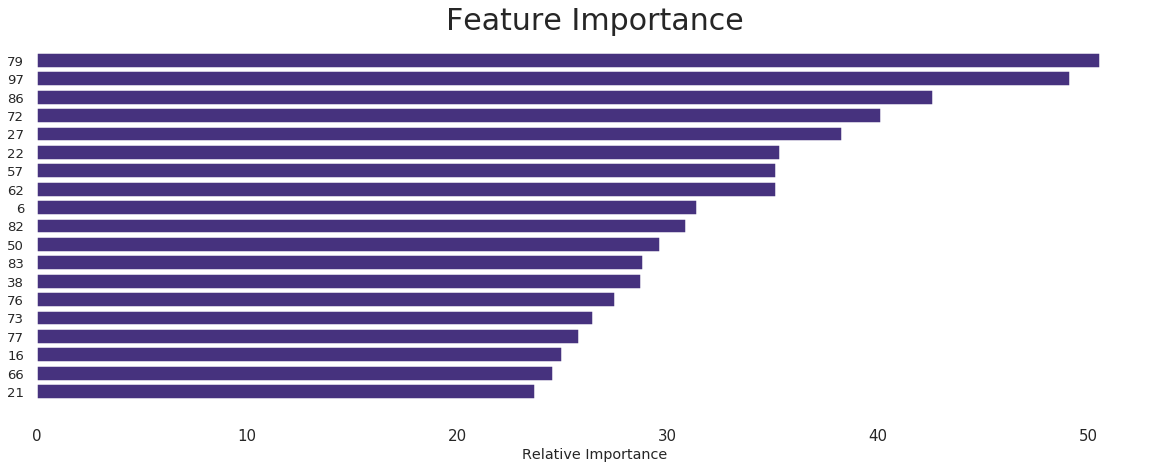

In [25]:
# checking which are the most important features
feature_importance = rfc.fit(recursive_features, y_train).feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
sorted_idx = sorted_idx[-20:-1:1]
pos = np.arange(sorted_idx.shape[0]) + .5
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train_df.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Feature Importance', fontsize=30)
plt.tick_params(axis='x', which='major', labelsize=15)
sns.despine(left=True, bottom=True)
plt.show()

Logistic Regression Public Leaderboard Score: 0.667

## 6. Feature selection using SelectFromModel

Like recursive feature selection, sklearn's SelectFromModel is used with any estimator that has a coef_ or feature_importances_ attribute. It removes features with values below a set threshold.


In [21]:
# feature extraction
select_model = feature_selection.SelectFromModel(lr)

# fit on train set
fit = select_model.fit(X_train, y_train)

# transform train set
model_features = fit.transform(X_train)

In [22]:
lr = LogisticRegression(solver='liblinear')
rfc = RandomForestClassifier(n_estimators=100)

lr_scores = cross_val_score(lr, model_features, y_train, cv=5, scoring='roc_auc')
rfc_scores = cross_val_score(rfc, model_features, y_train, cv=5, scoring='roc_auc')

print('LR Scores: ', lr_scores)
print('RFC Scores: ', rfc_scores)

LR Scores:  [0.984375   0.99479167 0.97222222 0.99305556 0.99305556]
RFC Scores:  [0.7734375  0.85590278 0.73697917 0.85850694 0.7734375 ]


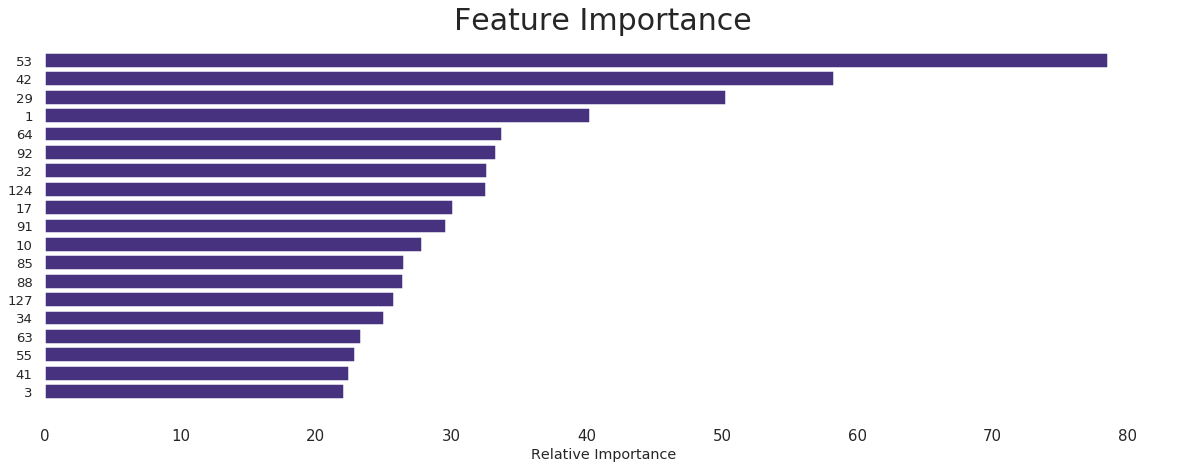

In [26]:
# checking which are the most important features
feature_importance = rfc.fit(model_features, y_train).feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
sorted_idx = sorted_idx[-20:-1:1]
pos = np.arange(sorted_idx.shape[0]) + .5
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train_df.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Feature Importance', fontsize=30)
plt.tick_params(axis='x', which='major', labelsize=15)
sns.despine(left=True, bottom=True)
plt.show()

## 7. PCA

PCA (Principle Component Analysis) is a dimensionality reduction technique that projects the data into a lower dimensional space.
While there are many effective dimensionality reduction techniques, PCA is the only example we will explore here.
PCA can be useful in many situations, but especially in cases with excessive multicollinearity or explanation of predictors is not a priority.

In [30]:
from sklearn.decomposition import PCA
# pca - keep 90% of variance
pca = PCA(0.90)

principal_components = pca.fit_transform(X_train)
principal_df = pd.DataFrame(data = principal_components)
principal_df.shape

(250, 139)

In [31]:
lr = LogisticRegression(solver='liblinear')
rfc = RandomForestClassifier(n_estimators=100)

lr_scores = cross_val_score(lr, principal_df, y_train, cv=5, scoring='roc_auc')
rfc_scores = cross_val_score(rfc, principal_df, y_train, cv=5, scoring='roc_auc')

print('LR Scores: ', lr_scores)
print('RFC Scores: ', rfc_scores)

LR Scores:  [0.80902778 0.703125   0.734375   0.80555556 0.66145833]
RFC Scores:  [0.5078125  0.72222222 0.68923611 0.63628472 0.49652778]


In [32]:
# pca keep 75% of variance
pca = PCA(0.75)
principal_components = pca.fit_transform(X_train)
principal_df = pd.DataFrame(data = principal_components)
principal_df.shape

(250, 93)

In [33]:
lr = LogisticRegression(solver='liblinear')
rfc = RandomForestClassifier(n_estimators=100)

lr_scores = cross_val_score(lr, principal_df, y_train, cv=5, scoring='roc_auc')
rfc_scores = cross_val_score(rfc, principal_df, y_train, cv=5, scoring='roc_auc')

print('LR Scores: ', lr_scores)
print('RFC Scores: ', rfc_scores)

LR Scores:  [0.72048611 0.60069444 0.68402778 0.71006944 0.61284722]
RFC Scores:  [0.54600694 0.57725694 0.66579861 0.6015625  0.69357639]


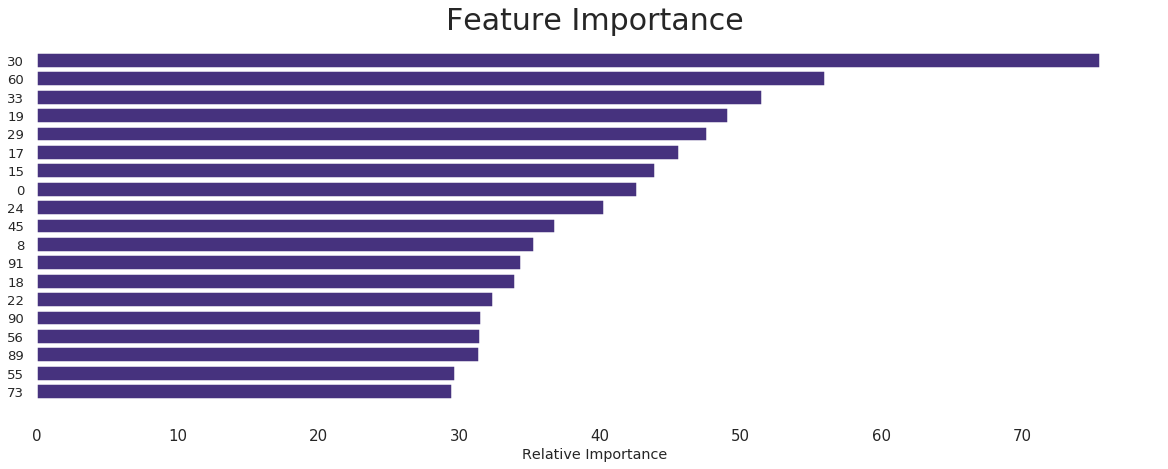

In [34]:
# checking which are the most important features
feature_importance = rfc.fit(principal_df, y_train).feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
sorted_idx = sorted_idx[-20:-1:1]
pos = np.arange(sorted_idx.shape[0]) + .5
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train_df.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Feature Importance', fontsize=30)
plt.tick_params(axis='x', which='major', labelsize=15)
sns.despine(left=True, bottom=True)
plt.show()

> Recursive feature selection appears to perform the best above.  We'll use our tuned hyperparameters from our [hyperparameter tuning kernel](https://www.kaggle.com/tboyle10/hyperparameter-tuning) and submit to the competition.

In [27]:
# feature extraction
rfe = feature_selection.RFE(lr, n_features_to_select=100)

# fit on train set
fit = rfe.fit(X_train, y_train)

# transform train set
recursive_X_train = fit.transform(X_train)
recursive_X_test = fit.transform(X_test)

lr = LogisticRegression(C=1, class_weight={1:0.6, 0:0.4}, penalty='l1', solver='liblinear')
lr_scores = cross_val_score(lr, recursive_X_train, y_train, cv=5, scoring='roc_auc')
lr_scores.mean()

0.9059027777777778

In [28]:
predictions = lr.fit(recursive_X_train, y_train).predict_proba(recursive_X_test)

In [ ]:
submission = pd.read_csv('../input/sample_submission.csv')
submission['target'] = predictions
submission.to_csv('submission.csv', index=False)
submission.head()